In [1]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 손절 전략 시스템

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [2]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
import datetime

In [3]:
#tf.keras.backend.set_floatx('float64')

In [4]:
import gc
gc.collect()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
#    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')    
    #tf.config.experimental.set_virtual_device_configuration(
    #    gpus[1],
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)

In [33]:
file_name = '~/Data/kospi200f_price_only_0515.csv'
item_name = 'kospi200f_손절'
train_start = '2000-01-31'
train_end = '2018-01-02'
test_start = '2019-01-02'
test_end = '2020-05-15'

remove_columns = ['date', '종가', '시가', '고가', '저가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'ddaeryuble6-kelly'
channel = False

trans_day = 10

target_alpha = 100
future_day = 1
n_timestep = 50
time_interval = 1
input_size = 37
n_unit = 50
batch_size = 10
learning_rate = 0.0005
epochs = 1000

alpha = 0.5

comment = ""

checkpoint_path = model_name + "/pred"+str(future_day)+"_trans"+str(trans_day)+".ckpt"

In [6]:
dataframe = pd.read_csv(file_name)
df = dataframe.copy()
#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) 
                                / df.loc[i, target_column]) * target_alpha 

In [ ]:
train_high_open = df['고가'].values[current_train_start_index + (n_timestep-1)*time_interval: current_train_end_index  + 1] - 
                    df['시가'].values[current_train_start_index + (n_timestep-1)*time_interval : current_train_end_index  + 1]
train_open_low = df['시가'].values[current_train_start_index + (n_timestep-1)*time_interval: current_train_end_index  + 1] - 
                    df['저가'].values[current_train_start_index + (n_timestep-1)*time_interval: current_train_end_index  + 1]    
test_high_open = df['고가'].values[test_start_index - future_day: test_end_index + 1] -
                  df['시가'].values[test_start_index - future_day: test_end_index + 1]
test_open_low = df['시가'].values[test_start_index - future_day: test_end_index + 1] -
                  df['저가'].values[test_start_index - future_day: test_end_index + 1]    
    
high_open = df.loc[(n_timestep-1)*time_interval:-future_day, '고가'] - df[(n_timestep-1)*time_interval:-future_day, '시가']
open_low = df[(n_timestep-1)*time_interval:-future_day, '시가'] - df[(n_timestep-1)*time_interval:-future_day, '저가']

In [7]:
df['종가'].values[:20]

array([-3.55351171,  2.68747291,  0.67539046,  2.59958071, -0.89906007,
        1.56701031, -0.24360536, -1.62800163, -4.01323955, -4.43965517,
        3.15741994, -1.48666375, -0.71016423, -4.60438087,  0.51546392,
        3.07692308, -1.53776572,  0.04593477, -6.06060606,  0.63538612])

In [8]:
"""
def loss_fn_(m, train_x, train_y):
    
    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))
    targets = train_y[:, n_timestep-1, 1:].reshape((-1))
    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))
    rates = (tagets - bse_prices) / base_prices
    updown = np.sign(targets - base_prices)
    preds = model(train_x)
    
    
    returns = [1.0]
    avg_return = 1.0
    avg_std = 0.0
    state = np.zeros((4))
    state[0] = 1.0 # average return
    state[1] = 0.0 # standard dev. of returns
    state[2] = 1.0
    state[3] = preds[train_x[0]]
    
    model2 = layers.Dense(units=10, activaton='tanh')
    
    #investment rate
    inv_r = np.zeros((len(train_y)))
    best_inv = np.zeros((len(train_y)))
    
    for i in range(len(targets)):
        state[0] = 
        state[1] = 
        state[2] = (len(train_y) - i) / len(train_y) 
        inv_r[i] = model2(state)
        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))
        
        r = tf.random.normal([100], mean=inv_r[i])
        sharp_ratio = np.zeros((len(r)))
        returns_random = [1.0]

        for j in range(len(r)):  
            returns_random.append(rates[i]*r[j] + 1-abs(r[j]))
            for k in range(i+1, len(train_y)):
                state[0] =
                state[1] = 
                state[2] = (len(train_y) - k) / len(train_y)
                inv_r[k] = model2(state, training=False)
                returns_random.append(rates[k]*inv_r[k] + 1-abs(inv_r[k]))
            avg_return = tf.math.reduce_prod(returns_random)**(1/(len(r)-i))
            std_return = tf.math.reduce_std(returns_random)
            sharp_ratio[j] = avg_return / std_return
        best_return_index = tf.math.argmax(sharp_ratio)
        best_inv[i] = r[best_return_index]

    return tf.math.square(inv_r - best_inv)
"""

"\ndef loss_fn_(m, train_x, train_y):\n    \n    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))\n    targets = train_y[:, n_timestep-1, 1:].reshape((-1))\n    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))\n    rates = (tagets - bse_prices) / base_prices\n    updown = np.sign(targets - base_prices)\n    preds = model(train_x)\n    \n    \n    returns = [1.0]\n    avg_return = 1.0\n    avg_std = 0.0\n    state = np.zeros((4))\n    state[0] = 1.0 # average return\n    state[1] = 0.0 # standard dev. of returns\n    state[2] = 1.0\n    state[3] = preds[train_x[0]]\n    \n    model2 = layers.Dense(units=10, activaton='tanh')\n    \n    #investment rate\n    inv_r = np.zeros((len(train_y)))\n    best_inv = np.zeros((len(train_y)))\n    \n    for i in range(len(targets)):\n        state[0] = \n        state[1] = \n        state[2] = (len(train_y) - i) / len(train_y) \n        inv_r[i] = model2(state)\n        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))\n        \n 

In [9]:
def make_remaining_days(n_batches, n_steps):
    remaining_days = []
    for i in range(n_batches):
        temp = []    
        for j in range(n_steps):
            temp.append((n_batches - i) / n_batches)
        remaining_days.append(np.array(temp))
    return np.array(remaining_days)

In [10]:
#@tf.function
def loss_fn_model1(m1, train_x, train_y):
    
    rates = train_y / 100
    updown = tf.math.sign(train_y)
    preds = tf.cast(m1(train_x), dtype=tf.float64)
    profits = tf.cast(tf.convert_to_tensor(rates, dtype=tf.float64)*tf.math.sign(preds), dtype=tf.float64)
    
    loss1 = keras.losses.MSE(preds, updown)
    
    batches = train_y.shape[0]
    steps = train_y.shape[1]     
    
    return_plus = []
    return_minus = []
    for i in range(batches):
        if profits[i, -1, 0] > 0: return_plus.append(profits[i, -1, 0])      
        else: return_minus.append(profits[i, -1, 0])    

    loss2 = tf.cast(tf.math.reduce_mean(return_plus), dtype=tf.float64) - tf.cast(tf.math.reduce_mean(return_minus), dtype=tf.float64) 
    
    return loss1 - loss2


In [11]:
#@tf.function
def loss_fn_model2(m1, m2, train_x, train_y):
    
    rates = train_y / 100
    updown = tf.math.sign(train_y)
    preds = tf.cast(m1(train_x), dtype=tf.float64)
    profits = tf.cast(tf.convert_to_tensor(rates, dtype=tf.float64)*tf.math.sign(preds), dtype=tf.float64)
    
    batches = train_y.shape[0]
    steps = train_y.shape[1]     
    
    kelly = []
    for i in range(profits.shape[0]):

        for j in range(steps):
            
            temp = tf.math.multiply(updown[:i+1, j, 0], preds[:i+1, j, 0])
            accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/(i+1)    
            
            plus = 0
            minus = 0            
            for k in range(i+1):
                if profits[k, j, 0] > 0:
                    plus += profits[k, j, 0]
                else: 
                    minus += profits[k, j, 0]
            avg_profit = plus / (i+1)
            avg_loss = minus / (i+1)
        
            kelly.append(accu/avg_loss - (1-accu)/avg_profit)
        
    loss = keras.losses.MSE(tf.reshape(m2(train_x), [-1]), np.array(kelly).reshape(batches, steps, 1))
    
   
    return loss

In [12]:
#@tf.function
def gradient1(model1, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model1(model1, input_data, output_data)
    return tape.gradient(loss, model1.trainable_variables)
#@tf.function
def gradient2(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model2.trainable_variables)

In [13]:

#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
model1 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
model2 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #    checkpoint_path, verbose=1, save_weights_only=True,
        # 다섯 번째 에포크마다 가중치를 저장합니다
    #    save_freq=5)

#    model.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])
            
#    model2 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#    model2.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])            

#modle_name = model_name + "tanh"            
#model.save_weights(checkpoint_path)
#model2.save_weights("modle2_"+ checkpoint_path)

In [14]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)

while True:

    gc.collect()
    
    train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)
    
    # input_size, columns reset
    input_size = len(df.columns) - len(remove_columns)
    input_columns = df.columns.copy()

    train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
    test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

    #model.compile(optimizer='adam',
    #          loss=loss_fn)
    #          #callbacks=[cp-callback]
    #          #metrics=['accuracy'])
    
    # the firs training dataset
    train_x = train_x[:-future_day]
    train_y = train_y[:-future_day]    
    
    #global_step = tf.train.get_or_create_global_step()
    global_step = tf.Variable(0, trainable=False)
    #lr_decay = tf.train.exponential_decay(learning_rate, global_step,
    #                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
    lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    updown = np.sign(test_y[:, -1, 0]).reshape((-1))    
    iter = epochs
    basic_epochs = tf.cast(epochs / 5, dtype=tf.int32)
    for iteration in range(iter):
        batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)
        
        gradients1 = gradient1(model1, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
        #gradients2 = gradient2(model1, model2, batch_input, batch_output)
        #optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
        if iteration % 100 == 0:
            #test_MSE = model.evaluate(test_x, test_y)
            prediction = model1.predict(test_x)
            prediction_MSE = sum((updown - prediction[:, -1, 0]).reshape(-1))**2/len(test_y)
            print('prediction_MSE =', prediction_MSE)

            #prediction = model2.predict(test_x)
            #print('kelly =', prediction[:, -1, 0])            
            
        if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
            break
     
    if iter > basic_epochs: iter -= basic_epochs
    if iter < basic_epochs: iter= basic_epochs

    print('test dates ' + current_test_start + "~" + current_test_end)
    
    #단순 예측
    #prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    #prediction_MSE = sum(test_y[:, -1, 0] - prediction[:, -1, 0]).reshape((-1))**2/len(test_y)
    #print('prediction_MSE =', prediction_MSE)

    # prediction1 accuracy
    prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    temp = tf.math.multiply(updown, prediction1)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('prediction1 accuracy = ', accu)

    # reinforced prediction2
    #prediction2 = model2.predict(test_x)[:, -1, 0].reshape(-1)
    
    test_prediction1.append(prediction1)
    #test_prediction2.append(prediction2)
    
    # escape from while
    if current_test_end == test_end:
     break

    #train, start dates shift
    current_train_start = df.loc[prepro.date_to_index(df, current_train_start) + trans_day, 'date']
    current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
    current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
        current_test_end = test_end
    else:
        current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

prediction_MSE = 4.230598127290409
prediction_MSE = 0.1527119248217936
prediction_MSE = 0.00012829128184711075
prediction_MSE = 0.4553907934166901
prediction_MSE = 0.27386120886625076
prediction_MSE = 0.23530482810653158
prediction_MSE = 0.40513467764158245
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-01-02~2019-01-15
prediction1 accuracy =  tf.Tensor(0.6, shape=(), dtype=float64)
prediction_MSE = 10.860158040691672
prediction_MSE = 2.8713068836605533
prediction_MS

prediction_MSE = 2.8000202513705874
prediction_MSE = 0.21135984562881874
step :  21
Training process is stopped early....
test dates 2019-10-25~2019-11-07
prediction1 accuracy =  tf.Tensor(0.3, shape=(), dtype=float64)
prediction_MSE = 3.161576245570794
prediction_MSE = 4.005054788118697
prediction_MSE = 3.5576017613837863
prediction_MSE = 4.380315120177897
prediction_MSE = 3.786234740180794
prediction_MSE = 3.665668279669467
step :  22
Training process is stopped early....
test dates 2019-11-08~2019-11-21
prediction1 accuracy =  tf.Tensor(0.5, shape=(), dtype=float64)
prediction_MSE = 0.508705555557265
prediction_MSE = 1.1574737050489599
prediction_MSE = 0.6005096514221336
prediction_MSE = 2.2237058175899898
prediction_MSE = 0.020853321348582553
prediction_MSE = 0.03280769604591536
step :  23
Training process is stopped early....
test dates 2019-11-22~2019-12-05
prediction1 accuracy =  tf.Tensor(0.6, shape=(), dtype=float64)
prediction_MSE = 0.7857678984420602
prediction_MSE = 4.06691

In [24]:
t1 = np.concatenate(test_prediction1)
t2 = t1
#t2 = np.concatenate(test_prediction2)

In [25]:
#t2

In [26]:
#test_prediction = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
#train_prediction = learn.predict_batch_test(model1, train_x[:batch_size], len(train_x[:batch_size]))

# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)

# 전체 test_oouput 생성
_, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                   train_start, train_end,
                                                   test_start, test_end,
                                                   future_day, n_timestep, time_interval)
_, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

In [27]:
updown = np.sign(test_y[:, -1, 0]).reshape((-1))
#calculate accuracy
temp = tf.math.multiply(updown, t1.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('accuracy = ', accu)

accuracy =  tf.Tensor(0.5161290322580645, shape=(), dtype=float64)


In [28]:
updown.shape

(310,)

In [29]:
#train_base_prices = train_base_prices[:batch_size]
#train_prediction = train_prediction[:batch_size]
#train_y = train_y[:batch_size]

In [30]:
result = GenerateResult(t1, t2, test_y[:, -1, 0].reshape(-1), test_dates, n_timestep, future_day, trans_day)

In [31]:
#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)

info : ddaeryuble6-kelly_kospi200f_reinfo_809_120_1_1_0.519
MSE : 3.0429 , Accuracy : 0.519
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/ddaeryuble6-kelly_kospi200f_reinfo_809_120_1_1_0.519/assets


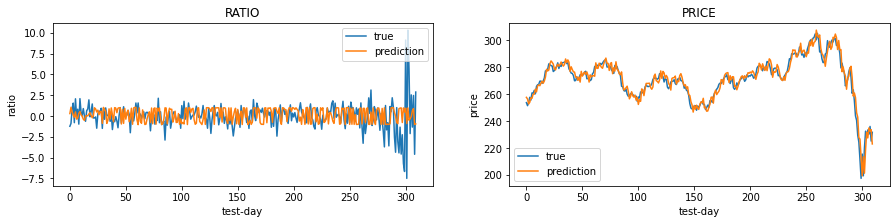

In [34]:
result.evaluation()
result.table()
result.save_result(model_name,item_name,n_unit,target_type,batch_size,n_timestep,time_interval,epochs,str(alpha), comment)
result.save_visualization()
result.save_model(model2)

In [ ]:
"""
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)


gc.collect()

train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                       current_train_start, current_train_end,
                                                       current_test_start, current_test_end,
                                                       future_day, n_timestep, time_interval)

# input_size, columns reset
input_size = len(df.columns) - len(remove_columns)
input_columns = df.columns.copy()

train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

#model.compile(optimizer='adam',
#          loss=loss_fn)
#          #callbacks=[cp-callback]
#          #metrics=['accuracy'])

# the firs training dataset
train_x = train_x[:-future_day]
train_y = train_y[:-future_day]    

#global_step = tf.train.get_or_create_global_step()
global_step = tf.Variable(0, trainable=False)
#lr_decay = tf.train.exponential_decay(learning_rate, global_step,
#                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

updown = np.sign(test_y[:, -1, 0]).reshape((-1))    
epochs = len(train_y)
for iteration in range(399):
    batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)

    #noise = 2*np.random.randn(batch_size,n_timestep,1)
    #batch_output = batch_output+noise
    #batch_input = encoder(train_input[idx])
    gradients1 = gradient1(model1, model2, batch_input, batch_output)
    optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.reshape(model1(train_x, training=False)[:, -1, 0], [-1])
    
    n = len(targets)    
    returns = [1.0]
    losses = []
    for i in range(n - 1):
       
        # average_return, std of returns, remaining days, preds[0] 
        state = []
        
        random_rates = []
        for k in range(i+1):
            random_rates.append(rates[k])
        # 실재 수익률을 기반으로 random 수익률 생성, 예측에 의한 porfits 생성 
        for k in range(i+1, n):
            random_rates.append(tf.random.normal((), mean=targets[k] / 100, stddev=0.1, dtype=tf.float64))
        profits = tf.convert_to_tensor(random_rates, dtype=tf.float64)*tf.cast(preds, dtype=tf.float64) + 1
        
        # 현재까지의 예측에 의한 수익률 기하평균 구하기
        returns_past = []
        for k in range(i+1):
            returns_past.append(profits[k])
        avg_return = tf.cast(tf.math.reduce_prod(returns_past)**(1/(i+1)), dtype=tf.float64)
        
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))
     
        # 목표일까지의 기대 기하 평균 수익률 구하기 
        returns_future = []
        for j in range(i+1, n):
            returns_future.append(profits[j])
        avg_return_future = tf.math.reduce_prod(returns_future)**(1/(n-i-1))

        # 예측 기하 평균 수익률과 기대 기하 평균 수익률의 MSE
        value = tf.cast(model2(state, training=True)[0, 0], dtype=tf.float64)
        losses.append((value - avg_return_future)**2)
        if n == 3: break
    print("losses", losses)
    print("value", value)    
    with tf.GradientTape() as tape:
        gradients2 = tape.gradient(tf.math.reduce_sum(losses), model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
    

    
    if iteration % 100 == 0:
        #test_MSE = model.evaluate(test_x, test_y)
        prediction = model1.predict(test_x)
        prediction_MSE = sum((updown - np.sign(prediction[:, -1, 0]).reshape(-1))**2)/len(test_y)
        print('prediction_MSE =', prediction_MSE)

    if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
        break
epochs -= epochs / 5
if epochs <= 0: epochs = 100
"""